In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import ssl

import torch as torch


def set_up_ssl():
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

set_up_ssl()

In [ ]:
LOCAL_M1 = False

if LOCAL_M1:
    device = 'cuda' if torch.cuda.is_available() else 'mps'
else:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print("Using device: ", device)

Using device:  cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.nn.utils.prune as prune
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

# from torchsummary import summary

import os
import sys
import time
import math
import argparse
import humanize
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print("Creating Tensorboard writer object")

TENSOR_BOARD_DIR = "runs/resnet_18"

writer = SummaryWriter(TENSOR_BOARD_DIR)

Creating Tensorboard writer object


In [ ]:
term_width = 5
TOTAL_BAR_LENGTH = 7
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [ ]:
'''ResNet in PyTorch.
For Pre-activation ResNet, see 'preact_resnet.py'.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, trial=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate = trial.suggest_float("dropout_rate", 0, 0.1, step=0.1)
            self.drop1 = nn.Dropout2d(p=dropout_rate)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)

        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.2, step=0.1)
            self.drop2 = nn.Dropout2d(p=dropout_rate2)

        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, trial=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)

        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate = trial.suggest_float("dropout_rate", 0, 0.1, step=0.1)
            self.drop1 = nn.Dropout2d(p=dropout_rate)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        
        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.2, step=0.1)
            self.drop2 = nn.Dropout2d(p=dropout_rate2)

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        
        # adding Optuna dropout trial
        if trial is not None:
            dropout_rate3 = trial.suggest_float("dropout_rate3", 0, 0.1,
                                                step=0.1)
            self.drop2 = nn.Dropout2d(p=dropout_rate3)

        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, trial=None):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)

        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], trial,
                                       stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], trial,
                                       stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], trial,
                                       stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], trial,
                                       stride=2)

        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, trial, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, trial))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(trial=None):
    return ResNet(BasicBlock, [2, 2, 2, 2], trial=trial)


def ResNet34(trial=None):
    return ResNet(BasicBlock, [3, 4, 6, 3], trial=trial)


def ResNet50(trial=None):
    return ResNet(Bottleneck, [3, 4, 6, 3], trial=trial)


def ResNet101(trial=None):
    return ResNet(Bottleneck, [3, 4, 23, 3], trial=trial)


def ResNet152(trial=None):
    return ResNet(Bottleneck, [3, 8, 36, 3], trial=trial)

In [ ]:
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# constructing validation set

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

torch.manual_seed(43)
val_size = 5000
train_size = len(trainset) - val_size

train_ds, val_ds = random_split(trainset, [train_size, val_size])
len(train_ds), len(val_ds)
print("The length of a train set is ", len(train_ds))
print("The length of a validation set is ", len(val_ds))
print("The length of a test set is ", len(testset))

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=128, shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=128, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

net = ResNet18() # 11.2 params
#net = ResNet50() # 23.5

==> Preparing data..


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
The length of a train set is  45000
The length of a validation set is  5000
The length of a test set is  10000


In [ ]:
layers = list(net.children())

print(len(layers))

print("layers[0]: ", layers[0])
print("layers[1]: ", layers[1])
print("layers[2]: ", layers[2])
print("layers[3]: ", layers[3])
print("layers[4]: ", layers[4])
print("layers[5]: ", layers[5])
print("layers[6]: ", layers[6])

7
layers[0]:  Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layers[1]:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
layers[2]:  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [ ]:
print("Installing Torch_Pruning module to be used for model size reduction")

!pip install torch_pruning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch_pruning as tp

def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    block_prune_probs = [0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3]
    blk_id = 0
    for m in model.modules():
        if isinstance( m, BasicBlock):
            prune_conv( m.conv1, block_prune_probs[blk_id] )
            prune_conv( m.conv2, block_prune_probs[blk_id] )
            blk_id+=1
    return model   

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_params(model):
  print("Number of parameters ", humanize.intword(count_parameters(model)))
  return

In [ ]:
print("The number of parameters before pruning is ")
print_params(net)

The number of parameters before pruning is 
Number of parameters  11.2 million


In [ ]:
print("Pruning the model...")
prune_model(net)

ResNet(
  (conv1): Conv2d(3, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(53, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(58, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(53, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(58, 53, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(53, eps=1e-05, momentum=0.1, affine=

In [ ]:
print("The number of parameters after pruning is ")
print_params(net)

The number of parameters after pruning is 
Number of parameters  4.5 million


In [ ]:
from torchsummary import summary

def print_model_summary(model):
  print(summary(model.to(device), (3, 32, 32)))

print_model_summary(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 53, 32, 32]           1,431
       BatchNorm2d-2           [-1, 53, 32, 32]             106
            Conv2d-3           [-1, 58, 32, 32]          27,666
       BatchNorm2d-4           [-1, 58, 32, 32]             116
            Conv2d-5           [-1, 53, 32, 32]          27,666
       BatchNorm2d-6           [-1, 53, 32, 32]             106
        BasicBlock-7           [-1, 53, 32, 32]               0
            Conv2d-8           [-1, 58, 32, 32]          27,666
       BatchNorm2d-9           [-1, 58, 32, 32]             116
           Conv2d-10           [-1, 53, 32, 32]          27,666
      BatchNorm2d-11           [-1, 53, 32, 32]             106
       BasicBlock-12           [-1, 53, 32, 32]               0
           Conv2d-13          [-1, 103, 16, 16]          49,131
      BatchNorm2d-14          [-1, 103,

In [ ]:
def print_model_layers(model):
  for name, param in model.named_parameters():
    print(name, param.size())

print_model_layers(net)

conv1.weight torch.Size([53, 3, 3, 3])
bn1.weight torch.Size([53])
bn1.bias torch.Size([53])
layer1.0.conv1.weight torch.Size([58, 53, 3, 3])
layer1.0.bn1.weight torch.Size([58])
layer1.0.bn1.bias torch.Size([58])
layer1.0.conv2.weight torch.Size([53, 58, 3, 3])
layer1.0.bn2.weight torch.Size([53])
layer1.0.bn2.bias torch.Size([53])
layer1.1.conv1.weight torch.Size([58, 53, 3, 3])
layer1.1.bn1.weight torch.Size([58])
layer1.1.bn1.bias torch.Size([58])
layer1.1.conv2.weight torch.Size([53, 58, 3, 3])
layer1.1.bn2.weight torch.Size([53])
layer1.1.bn2.bias torch.Size([53])
layer2.0.conv1.weight torch.Size([103, 53, 3, 3])
layer2.0.bn1.weight torch.Size([103])
layer2.0.bn1.bias torch.Size([103])
layer2.0.conv2.weight torch.Size([83, 103, 3, 3])
layer2.0.bn2.weight torch.Size([83])
layer2.0.bn2.bias torch.Size([83])
layer2.0.shortcut.0.weight torch.Size([83, 53, 1, 1])
layer2.0.shortcut.1.weight torch.Size([83])
layer2.0.shortcut.1.bias torch.Size([83])
layer2.1.conv1.weight torch.Size([103

In [ ]:
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

# ********* Hand-Set model parameters ***********

lr = 0.01

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=lr,
                       momentum=0.9, weight_decay=5e-4)

# ********* Hand-Set model parameters ***********

# *********** model parameters found with Optuna ************** #

batch_size = 128

lr = 0.0008781984559717051

momentum = 0.26582732909111395

optimizer = optim.RMSprop(net.parameters(), lr=lr,
                       momentum = momentum)

trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

# *********** model parameters found with Optuna ************** #


# writing data to TensorBoard
images, labels = next(iter(trainloader))

grid = torchvision.utils.make_grid(images)
writer.add_image('images', grid, 0)
writer.add_graph(net, images)
writer.close()

# --------------------------------------- # 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

save_loss = {'train':[], 'test':[]}
save_acc = {'train':[], 'test':[]}

train_acc_array, train_loss_array = [], [] # for plotting
val_acc_array, val_loss_array = [], [] # for plotting

In [ ]:
# Training
def train(epoch, model=net, train_loader=trainloader, optim=optimizer):
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    train_acc = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        train_acc=100.*correct/total
        progress_bar(batch_idx, len(train_loader), 'Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

    train_acc_array.append(train_acc) # for plottting
    train_loss_array.append(train_loss) # for plottting
    writer.add_scalar('training loss', train_loss)
    writer.add_scalar('training accuracy', train_acc)


In [ ]:
def evaluate(epoch, model=net, validation_loader=val_loader): # validation
   
    global best_acc
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(validation_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            valid_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(validation_loader), 'Valid Loss: %.3f | Valid Acc: %.3f%% (%d/%d)'
                         % (valid_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    valid_acc = 100.*correct/total
    if valid_acc > best_acc:
        print('Saving..')
        state = {
            'net_state_dict': model.state_dict(),
            'acc': valid_acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = valid_acc
    val_acc_array.append(valid_acc) # for plottting
    val_loss_array.append(valid_loss) # for plottting
    writer.add_scalar('validation loss', valid_loss)
    writer.add_scalar('validation accuracy', valid_acc)
    return valid_acc

In [ ]:
# Load the best model parameters (measured in terms of validation loss) and evaluate the loss/accuracy on the test set.
def test(model=net):
   
    test_loss = 0
    correct = 0
    total = 0
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['net_state_dict'])
    best_epoch = checkpoint['epoch']
    best_acc = checkpoint['acc']
    model.eval()
    print(f'Best validation acc: {best_acc:.3f}% at Epoch {best_epoch}')
    with torch.no_grad():
          
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))


In [ ]:
print("Using device ", device)

Using device  cuda


In [ ]:
print("The number of parameters before training is ")
print_params(net)

Number of parameters  4.5 million


In [ ]:
NUM_EPOCHS = 200

print("Training the model for ", NUM_EPOCHS)

for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    scheduler.step()
    train(epoch)
    evaluate(epoch)

print('---------------------------------------- Testing Model... ----------------------------------------')
test()


Epoch: 0
 [======>]  Step: 50ms | Tot: 28s665ms | Train Loss: 1.111 | Train Acc: 60.824% (27371/45000) 352/352 
 [======>]  Step: 9ms | Tot: 2s13ms | Valid Loss: 1.031 | Valid Acc: 63.080% (3154/5000) 40/40 
Saving..

Epoch: 1
 [======>]  Step: 48ms | Tot: 28s759ms | Train Loss: 0.947 | Train Acc: 66.471% (29912/45000) 352/352 
 [======>]  Step: 9ms | Tot: 2s22ms | Valid Loss: 1.005 | Valid Acc: 63.840% (3192/5000) 40/40 
Saving..

Epoch: 2
 [======>]  Step: 49ms | Tot: 28s453ms | Train Loss: 0.857 | Train Acc: 70.096% (31543/45000) 352/352 
 [======>]  Step: 10ms | Tot: 1s988ms | Valid Loss: 0.932 | Valid Acc: 67.060% (3353/5000) 40/40 
Saving..

Epoch: 3
 [======>]  Step: 50ms | Tot: 28s522ms | Train Loss: 0.774 | Train Acc: 72.878% (32795/45000) 352/352 
 [======>]  Step: 7ms | Tot: 2s14ms | Valid Loss: 0.810 | Valid Acc: 71.040% (3552/5000) 40/40 
Saving..

Epoch: 4
 [======>]  Step: 48ms | Tot: 28s418ms | Train Loss: 0.717 | Train Acc: 74.871% (336

In [ ]:
print("The number of parameters after the training is ")
print_params(net)

Number of parameters  4.5 million


In [ ]:
max_train_acc = max(train_acc_array)

print("The highest training accuracy achieved is ", max_train_acc)

max_val_acc = max(val_acc_array)

print("The highest validation accuracy achieved is ", max_val_acc)

[24.788888888888888,
 38.593333333333334,
 51.28,
 10.171830484330485,
 10.211894586894587,
 10.249732905982906,
 10.1696047008547,
 10.122863247863247,
 10.27199074074074,
 10.225249287749287,
 10.243055555555555,
 10.145121082621083,
 10.109508547008547,
 9.866071428571429,
 10.0,
 10.071428571428571,
 9.908482142857142,
 9.977678571428571,
 9.964285714285714,
 9.959821428571429,
 9.890625,
 9.991071428571429,
 9.915178571428571,
 9.452902421652421,
 9.428418803418804,
 9.437321937321938,
 9.41951566951567,
 9.339387464387464,
 9.486289173789174,
 9.524127492877493,
 9.51522435897436,
 9.346064814814815,
 9.479611823361823,
 10.024928774928775,
 9.991542022792023,
 10.011574074074074,
 10.009348290598291,
 60.824444444444445,
 66.47111111111111,
 70.09555555555555,
 72.87777777777778,
 74.8711111111111,
 76.37777777777778,
 78.02222222222223,
 79.0911111111111,
 80.01555555555555,
 81.11111111111111,
 81.70444444444445,
 82.68666666666667,
 83.04888888888888,
 83.60666666666667,
 84.

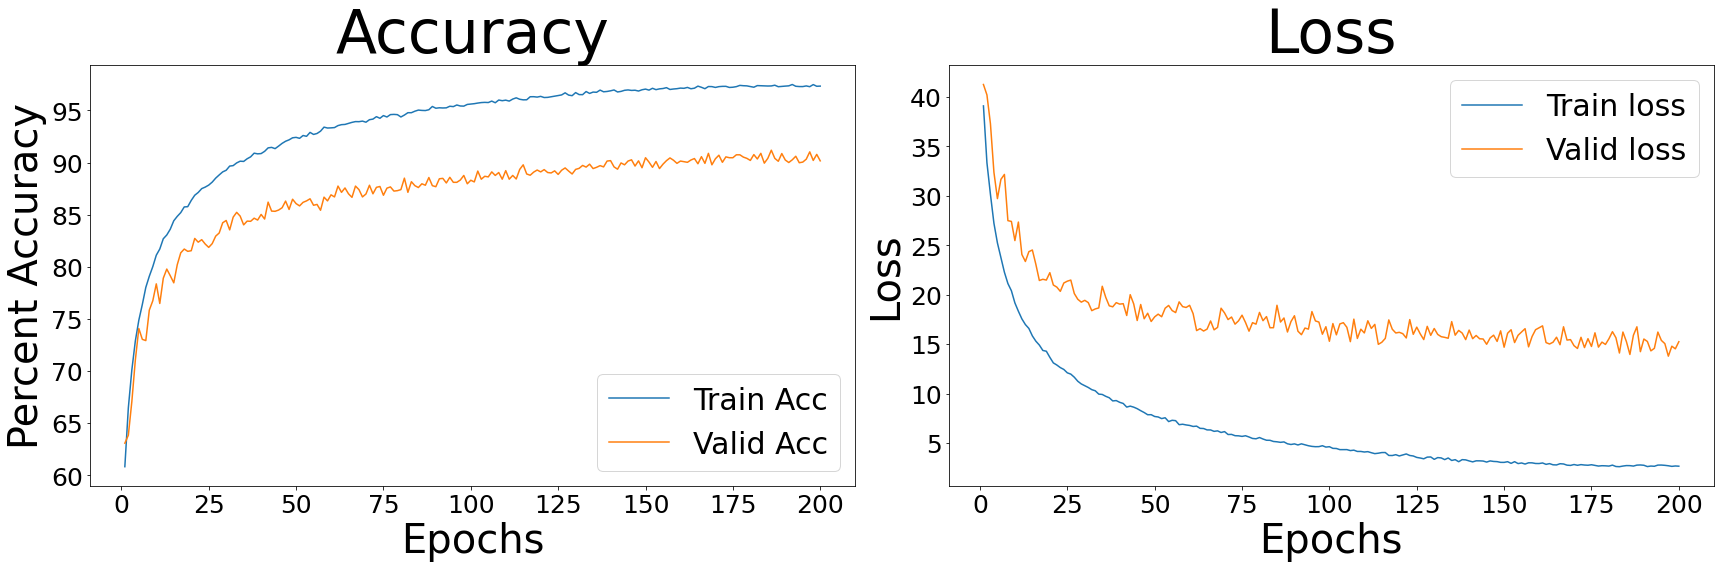

In [ ]:
print("Plotting the result...")
train_loss_array2=[i/10 for i in train_loss_array]
fig = plt.figure(figsize=(24,8))
ax = plt.axes()
plt.subplot(121)
plt.plot(np.arange(1,NUM_EPOCHS+1), train_acc_array[37:])
plt.plot(np.arange(1,NUM_EPOCHS+1),val_acc_array[37:])
plt.title("Accuracy", fontsize=60)
plt.xlabel("Epochs", fontsize=40)
plt.ylabel("Percent Accuracy", fontsize=40)
plt.legend(["Train Acc","Valid Acc"],loc = "lower right", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.subplot(122)
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),train_loss_array2[37:])
plt.plot(np.arange(1,NUM_EPOCHS+1,dtype=int),val_loss_array[37:])
plt.title("Loss", fontsize=60)
plt.xlabel("Epochs", fontsize=40)
plt.ylabel("Loss", fontsize=40)
plt.legend(['Train loss', 'Valid loss'], loc="upper right", fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.savefig("pruning_curves.pdf")
plt.show()

In [ ]:
def plot_test_result(num_epochs, train_acc, train_loss, val_acc, val_loss):
  fig = plt.figure(figsize=(16,6))
  plt.subplot(121)
  plt.plot(np.arange(1, num_epochs + 1), train_acc)
  plt.plot(np.arange(1, num_epochs + 1), val_acc)
  plt.title("Accuray")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Train Acc","Valid Acc"],loc = "upper right")

  plt.subplot(122)
  plt.plot(np.arange(1, num_epochs + 1, dtype=int), train_loss)
  plt.plot(np.arange(1, num_epochs + 1, dtype=int), val_loss)
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(['train loss', 'valid loss'], loc="upper right")

  plt.show()

<h2>Automatic Hyperparameter Search using Optuna</h2>

In [ ]:
print("Installing Optuna framework")
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

In [ ]:
# defining objective fucntion to be maximized by Optuna

def objective(trial):

  # generate a model
  curr_model = ResNet18(trial).to(device)

  prune_model(curr_model)

  if device == 'cuda':
    curr_model = torch.nn.DataParallel(curr_model)
    cudnn.benchmark = True


  # trying different optimizers
  optimizer_name_class_1 = trial.suggest_categorical("optimizer", ["SGD",
                                                                   "RMSprop"])

  # optimizer_name_class_2 = trial.suggest_categorical("optimizer", ["Adam",
  #                                                                  "Adadelta", "Adagrad", "ASGD"])
  
  momentum = trial.suggest_float("momentum", 0.0, 1.0)
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

  optimizer_class_1 = getattr(optim, optimizer_name_class_1)(curr_model.parameters(),
                                                     lr=lr, momentum=momentum)

  # optimizer_class_2 = getattr(optim, optimizer_name_class_2)(curr_model.parameters(),lr=lr)

  curr_batch_size = trial.suggest_int("batch_size", 128, 256, step=64)

  # defining a loss function
  criterion = nn.CrossEntropyLoss()

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_class_1, T_max=200)

  # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_class_2, T_max=200)

  val_size = 5000
  train_size = len(trainset) - val_size

  train_ds, val_ds = random_split(trainset, [train_size, val_size])

  curr_trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2, drop_last=True)
  
  val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2)

  # we will run the model for 200 epochs once the best parameters are 
  # discovered 
  NUM_EPOCHS = 20

  for epoch in range(0, NUM_EPOCHS):
      scheduler.step()
      train(epoch, model=curr_model, train_loader=curr_trainloader, optim=optimizer_class_1)
      accuracy = evaluate(epoch, model=curr_model, validation_loader=val_loader)
      trial.report(accuracy, epoch)

      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

  return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), study_name="resNet-18")

study.optimize(objective, n_trials = 10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-11-22 17:26:08,634] A new study created in memory with name: resNet-18



Epoch: 0
 [======>]  Step: 152ms | Tot: 26s307ms | Train Loss: 2.876 | Train Acc: 14.353% (6430/44800) 175/175 
 [======>]  Step: 27ms | Tot: 1s872ms | Valid Loss: 2.263 | Valid Acc: 14.560% (728/5000) 20/20 

Epoch: 1
 [======>]  Step: 149ms | Tot: 26s388ms | Train Loss: 2.053 | Train Acc: 19.752% (8849/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s743ms | Valid Loss: 2.090 | Valid Acc: 18.920% (946/5000) 20/20 

Epoch: 2
 [======>]  Step: 148ms | Tot: 26s118ms | Train Loss: 1.937 | Train Acc: 26.750% (11984/44800) 175/175 
 [======>]  Step: 27ms | Tot: 2s285ms | Valid Loss: 1.912 | Valid Acc: 28.800% (1440/5000) 20/20 

Epoch: 3
 [======>]  Step: 149ms | Tot: 26s391ms | Train Loss: 1.768 | Train Acc: 34.654% (15525/44800) 175/175 
 [======>]  Step: 29ms | Tot: 1s799ms | Valid Loss: 2.081 | Valid Acc: 31.260% (1563/5000) 20/20 

Epoch: 4
 [======>]  Step: 147ms | Tot: 26s239ms | Train Loss: 1.600 | Train Acc: 41.308% (18506/44800) 175/175 
 [====

[I 2022-11-22 17:35:49,435] Trial 0 finished with value: 74.08 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.2, 'optimizer': 'RMSprop', 'momentum': 0.27825018865449946, 'lr': 0.03705955361405272, 'batch_size': 256}. Best is trial 0 with value: 74.08.



Epoch: 0
 [======>]  Step: 149ms | Tot: 26s561ms | Train Loss: 2.031 | Train Acc: 24.038% (10769/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s727ms | Valid Loss: 1.871 | Valid Acc: 31.380% (1569/5000) 20/20 

Epoch: 1
 [======>]  Step: 149ms | Tot: 26s719ms | Train Loss: 1.698 | Train Acc: 37.346% (16731/44800) 175/175 
 [======>]  Step: 29ms | Tot: 1s716ms | Valid Loss: 1.662 | Valid Acc: 39.920% (1996/5000) 20/20 

Epoch: 2
 [======>]  Step: 151ms | Tot: 26s559ms | Train Loss: 1.444 | Train Acc: 47.817% (21422/44800) 175/175 
 [======>]  Step: 30ms | Tot: 1s790ms | Valid Loss: 1.477 | Valid Acc: 46.960% (2348/5000) 20/20 

Epoch: 3
 [======>]  Step: 151ms | Tot: 26s604ms | Train Loss: 1.241 | Train Acc: 55.618% (24917/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s761ms | Valid Loss: 1.248 | Valid Acc: 56.160% (2808/5000) 20/20 

Epoch: 4
 [======>]  Step: 154ms | Tot: 26s556ms | Train Loss: 1.079 | Train Acc: 61.413% (27513/44800) 175/175 
 [

[I 2022-11-22 17:45:35,840] Trial 1 finished with value: 81.6 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.2, 'optimizer': 'RMSprop', 'momentum': 0.876498817866124, 'lr': 0.0007834902289043906, 'batch_size': 256}. Best is trial 1 with value: 81.6.



Epoch: 0
 [======>]  Step: 107ms | Tot: 26s812ms | Train Loss: 9.752 | Train Acc: 10.067% (4523/44928) 234/234 
 [======>]  Step: 9ms | Tot: 1s824ms | Valid Loss: 2.381 | Valid Acc: 9.640% (482/5000) 27/27 

Epoch: 1
 [======>]  Step: 109ms | Tot: 26s198ms | Train Loss: 2.317 | Train Acc: 9.920% (4457/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s844ms | Valid Loss: 2.345 | Valid Acc: 9.980% (499/5000) 27/27 

Epoch: 2
 [======>]  Step: 112ms | Tot: 26s363ms | Train Loss: 2.318 | Train Acc: 9.920% (4457/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s861ms | Valid Loss: 2.350 | Valid Acc: 10.360% (518/5000) 27/27 

Epoch: 3
 [======>]  Step: 109ms | Tot: 26s5ms | Train Loss: 2.318 | Train Acc: 10.107% (4541/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s860ms | Valid Loss: 2.324 | Valid Acc: 10.360% (518/5000) 27/27 

Epoch: 4
 [======>]  Step: 110ms | Tot: 26s173ms | Train Loss: 2.319 | Train Acc: 10.009% (4497/44928) 234/234 
 [======>]  Step: 

[I 2022-11-22 17:55:11,248] Trial 2 finished with value: 10.2 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'RMSprop', 'momentum': 0.7111298530061423, 'lr': 0.08934010704973969, 'batch_size': 192}. Best is trial 1 with value: 81.6.



Epoch: 0
 [======>]  Step: 115ms | Tot: 27s180ms | Train Loss: 1.865 | Train Acc: 30.740% (13811/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s872ms | Valid Loss: 1.839 | Valid Acc: 34.800% (1740/5000) 27/27 

Epoch: 1
 [======>]  Step: 114ms | Tot: 27s202ms | Train Loss: 1.424 | Train Acc: 48.540% (21808/44928) 234/234 
 [======>]  Step: 8ms | Tot: 1s838ms | Valid Loss: 1.465 | Valid Acc: 47.500% (2375/5000) 27/27 

Epoch: 2
 [======>]  Step: 115ms | Tot: 27s160ms | Train Loss: 1.171 | Train Acc: 58.218% (26156/44928) 234/234 
 [======>]  Step: 11ms | Tot: 1s822ms | Valid Loss: 1.138 | Valid Acc: 59.040% (2952/5000) 27/27 

Epoch: 3
 [======>]  Step: 115ms | Tot: 27s270ms | Train Loss: 0.985 | Train Acc: 65.347% (29359/44928) 234/234 
 [======>]  Step: 9ms | Tot: 1s894ms | Valid Loss: 1.011 | Valid Acc: 63.480% (3174/5000) 27/27 

Epoch: 4
 [======>]  Step: 115ms | Tot: 27s209ms | Train Loss: 0.891 | Train Acc: 68.372% (30718/44928) 234/234 
 [==

[I 2022-11-22 18:05:11,825] Trial 3 finished with value: 80.28 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.1, 'optimizer': 'SGD', 'momentum': 0.9476183784592693, 'lr': 0.015770633845970158, 'batch_size': 192}. Best is trial 1 with value: 81.6.



Epoch: 0
 [======>]  Step: 150ms | Tot: 26s402ms | Train Loss: 2.300 | Train Acc: 12.321% (5520/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s838ms | Valid Loss: 2.283 | Valid Acc: 12.800% (640/5000) 20/20 

Epoch: 1
 [======>]  Step: 150ms | Tot: 26s461ms | Train Loss: 2.265 | Train Acc: 14.850% (6653/44800) 175/175 
 [======>]  Step: 30ms | Tot: 2s72ms | Valid Loss: 2.248 | Valid Acc: 16.040% (802/5000) 20/20 

Epoch: 2
 [======>]  Step: 149ms | Tot: 26s463ms | Train Loss: 2.234 | Train Acc: 16.913% (7577/44800) 175/175 
 [======>]  Step: 30ms | Tot: 1s745ms | Valid Loss: 2.217 | Valid Acc: 17.460% (873/5000) 20/20 

Epoch: 3
 [======>]  Step: 148ms | Tot: 26s419ms | Train Loss: 2.202 | Train Acc: 18.355% (8223/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s807ms | Valid Loss: 2.190 | Valid Acc: 18.880% (944/5000) 20/20 

Epoch: 4
 [======>]  Step: 148ms | Tot: 26s400ms | Train Loss: 2.168 | Train Acc: 19.850% (8893/44800) 175/175 
 [======>]  

[I 2022-11-22 18:15:00,841] Trial 4 finished with value: 32.02 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.2, 'optimizer': 'SGD', 'momentum': 0.5093631153443452, 'lr': 0.00019236486028456414, 'batch_size': 256}. Best is trial 1 with value: 81.6.



Epoch: 0
 [======>]  Step: 150ms | Tot: 26s918ms | Train Loss: 2.280 | Train Acc: 15.522% (6954/44800) 175/175 
 [======>]  Step: 27ms | Tot: 1s776ms | Valid Loss: 2.222 | Valid Acc: 17.620% (881/5000) 20/20 

Epoch: 1
 [======>]  Step: 155ms | Tot: 26s677ms | Train Loss: 2.147 | Train Acc: 21.310% (9547/44800) 175/175 
 [======>]  Step: 30ms | Tot: 1s833ms | Valid Loss: 2.085 | Valid Acc: 23.580% (1179/5000) 20/20 

Epoch: 2
 [======>]  Step: 149ms | Tot: 26s677ms | Train Loss: 2.007 | Train Acc: 26.808% (12010/44800) 175/175 
 [======>]  Step: 30ms | Tot: 1s792ms | Valid Loss: 1.939 | Valid Acc: 27.520% (1376/5000) 20/20 


[I 2022-11-22 18:16:29,453] Trial 5 pruned. 



Epoch: 0
 [======>]  Step: 79ms | Tot: 28s303ms | Train Loss: 2.201 | Train Acc: 20.339% (9138/44928) 351/351 
 [======>]  Step: 10ms | Tot: 1s944ms | Valid Loss: 2.023 | Valid Acc: 24.960% (1248/5000) 40/40 

Epoch: 1
 [======>]  Step: 77ms | Tot: 28s365ms | Train Loss: 1.760 | Train Acc: 35.408% (15908/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s976ms | Valid Loss: 1.557 | Valid Acc: 43.340% (2167/5000) 40/40 

Epoch: 2
 [======>]  Step: 82ms | Tot: 29s154ms | Train Loss: 1.407 | Train Acc: 49.321% (22159/44928) 351/351 
 [======>]  Step: 13ms | Tot: 2s332ms | Valid Loss: 1.644 | Valid Acc: 45.960% (2298/5000) 40/40 

Epoch: 3
 [======>]  Step: 78ms | Tot: 29s261ms | Train Loss: 1.185 | Train Acc: 57.784% (25961/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s943ms | Valid Loss: 1.273 | Valid Acc: 56.760% (2838/5000) 40/40 

Epoch: 4
 [======>]  Step: 81ms | Tot: 28s275ms | Train Loss: 1.033 | Train Acc: 63.304% (28441/44928) 351/351 
 [======>]

[I 2022-11-22 18:26:54,208] Trial 6 finished with value: 80.7 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.0, 'optimizer': 'RMSprop', 'momentum': 0.691539662345516, 'lr': 0.008955444489335542, 'batch_size': 128}. Best is trial 1 with value: 81.6.



Epoch: 0
 [======>]  Step: 112ms | Tot: 27s294ms | Train Loss: 1.842 | Train Acc: 31.775% (14276/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s969ms | Valid Loss: 1.780 | Valid Acc: 37.960% (1898/5000) 27/27 

Epoch: 1
 [======>]  Step: 112ms | Tot: 27s194ms | Train Loss: 1.458 | Train Acc: 47.062% (21144/44928) 234/234 
 [======>]  Step: 9ms | Tot: 1s984ms | Valid Loss: 1.525 | Valid Acc: 47.300% (2365/5000) 27/27 

Epoch: 2
 [======>]  Step: 114ms | Tot: 27s256ms | Train Loss: 1.256 | Train Acc: 55.346% (24866/44928) 234/234 
 [======>]  Step: 8ms | Tot: 1s950ms | Valid Loss: 1.254 | Valid Acc: 54.980% (2749/5000) 27/27 

Epoch: 3
 [======>]  Step: 115ms | Tot: 27s225ms | Train Loss: 1.110 | Train Acc: 60.274% (27080/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s911ms | Valid Loss: 1.274 | Valid Acc: 56.360% (2818/5000) 27/27 

Epoch: 4
 [======>]  Step: 115ms | Tot: 27s242ms | Train Loss: 1.007 | Train Acc: 64.336% (28905/44928) 234/234 
 [==

[I 2022-11-22 18:36:55,206] Trial 7 finished with value: 75.32 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.1, 'optimizer': 'SGD', 'momentum': 0.5209478103548258, 'lr': 0.012223134652644843, 'batch_size': 192}. Best is trial 1 with value: 81.6.



Epoch: 0
 [======>]  Step: 77ms | Tot: 28s170ms | Train Loss: 1.759 | Train Acc: 35.210% (15819/44928) 351/351 
 [======>]  Step: 13ms | Tot: 1s935ms | Valid Loss: 1.620 | Valid Acc: 44.260% (2213/5000) 40/40 

Epoch: 1
 [======>]  Step: 78ms | Tot: 28s241ms | Train Loss: 1.261 | Train Acc: 55.021% (24720/44928) 351/351 
 [======>]  Step: 8ms | Tot: 1s979ms | Valid Loss: 1.420 | Valid Acc: 52.680% (2634/5000) 40/40 

Epoch: 2
 [======>]  Step: 80ms | Tot: 28s266ms | Train Loss: 1.028 | Train Acc: 63.593% (28571/44928) 351/351 
 [======>]  Step: 8ms | Tot: 1s999ms | Valid Loss: 1.220 | Valid Acc: 57.200% (2860/5000) 40/40 

Epoch: 3
 [======>]  Step: 79ms | Tot: 28s123ms | Train Loss: 0.889 | Train Acc: 68.892% (30952/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s970ms | Valid Loss: 0.855 | Valid Acc: 70.460% (3523/5000) 40/40 

Epoch: 4
 [======>]  Step: 78ms | Tot: 28s187ms | Train Loss: 0.803 | Train Acc: 71.830% (32272/44928) 351/351 
 [======>]

[I 2022-11-22 18:47:15,529] Trial 8 finished with value: 81.14 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'SGD', 'momentum': 0.8513839372427039, 'lr': 0.019973362232791177, 'batch_size': 128}. Best is trial 1 with value: 81.6.



Epoch: 0
 [======>]  Step: 78ms | Tot: 28s253ms | Train Loss: 2.523 | Train Acc: 14.207% (6383/44928) 351/351 
 [======>]  Step: 8ms | Tot: 1s991ms | Valid Loss: 2.148 | Valid Acc: 16.280% (814/5000) 40/40 


[I 2022-11-22 18:47:46,661] Trial 9 pruned. 


Accuracy: 81.6
Best hyperparameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.2, 'optimizer': 'RMSprop', 'momentum': 0.876498817866124, 'lr': 0.0007834902289043906, 'batch_size': 256}


In [ ]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)

In [ ]:
from IPython.display import display

display(df)

,value,params_batch_size,params_dropout_rate,params_dropout_rate2,params_lr,params_momentum,params_optimizer
0,74.08,256,0.1,0.2,0.037060,0.278250,RMSprop
1,81.60,256,0.1,0.2,0.000783,0.876499,RMSprop
2,10.20,192,0.0,0.1,0.089340,0.711130,RMSprop
3,80.28,192,0.1,0.1,0.015771,0.947618,SGD
4,32.02,256,0.1,0.2,0.000192,0.509363,SGD
5,27.52,256,0.0,0.0,0.001445,0.110993,SGD
6,80.70,128,0.1,0.0,0.008955,0.691540,RMSprop
7,75.32,192,0.1,0.1,0.012223,0.520948,SGD
8,81.14,128,0.0,0.1,0.019973,0.851384,SGD
9,16.28,128,0.1,0.2,0.014143,0.890543,RMSprop


In [ ]:
from pathlib import Path  
filepath = Path('optuna_out.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 

In [ ]:
opt_hist = optuna.visualization.plot_optimization_history(study)

opt_hist.update_layout(
    yaxis=dict(
        titlefont=dict(size=30),
    ),

    xaxis=dict(
        titlefont=dict(size=30),
    ),

    font=dict(
        size = 30
    )
)

opt_hist.show()

In [ ]:
optuna.visualization.plot_contour(study, params=['batch_size', 'lr'])

In [ ]:
param_importance_fig = optuna.visualization.plot_param_importances(study)

param_importance_fig.update_layout(
    yaxis=dict(
        titlefont=dict(size=30),
    ),

    xaxis=dict(
        titlefont=dict(size=30),
    ),

    font=dict(
        size = 30
    )
)

param_importance_fig.show()

In [ ]:
from optuna.trial import TrialState
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

  Number of finished trials:  10
  Number of pruned trials:  2
  Number of complete trials:  8


In [ ]:
# serialize the reult

SERIALIZATION_DIR = "" 

import pickle

with open('study_optuna_nov_21.pickle', 'wb') as f:
    pickle.dump(study, f)

with open('df_optuna_nov_21.pickle', 'wb') as f:
    pickle.dump(df, f)

In [ ]:
print("The best model is")

print(trial.params)

The best model is
{'dropout_rate': 0.1, 'dropout_rate2': 0.2, 'optimizer': 'RMSprop', 'momentum': 0.876498817866124, 'lr': 0.0007834902289043906, 'batch_size': 256}


In [ ]:
# searching for the best Hyperparameters using a different family of optimizers 

def objective_2(trial):

  # generate a model
  curr_model = ResNet18(trial).to(device)

  prune_model(curr_model)

  if device == 'cuda':
    curr_model = torch.nn.DataParallel(curr_model)
    cudnn.benchmark = True


  # trying different optimizers

  optimizer_name_class_2 = trial.suggest_categorical("optimizer", ["Adam",
                                                                   "Adadelta", "Adagrad", "ASGD"])
  
  momentum = trial.suggest_float("momentum", 0.0, 1.0)
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

  optimizer_class_2 = getattr(optim, optimizer_name_class_2)(curr_model.parameters(),lr=lr)

  curr_batch_size = trial.suggest_int("batch_size", 128, 256, step=64)

  # defining a loss function
  criterion = nn.CrossEntropyLoss()

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_class_2, T_max=200)

  val_size = 5000
  train_size = len(trainset) - val_size

  train_ds, val_ds = random_split(trainset, [train_size, val_size])

  curr_trainloader = torch.utils.data.DataLoader(
    train_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2, drop_last=True)
  
  val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=curr_batch_size, shuffle=True, num_workers=2)

  # run for 200 epochs once the best model is found 
  NUM_EPOCHS = 20

  for epoch in range(0, NUM_EPOCHS):
      scheduler.step()
      train(epoch, model=curr_model, train_loader=curr_trainloader, optim=optimizer_class_2)
      accuracy = evaluate(epoch, model=curr_model, validation_loader=val_loader)
      trial.report(accuracy, epoch)

      if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

  return accuracy

In [75]:
print("Running Optuna with Ada family optimizers")

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), study_name="resNet-18-Ada")

study.optimize(objective_2, n_trials = 10)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-11-22 18:49:06,359] A new study created in memory with name: resNet-18-Ada


Running Optuna with Ada family optimizers

Epoch: 0


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning:

Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate



 [======>]  Step: 119ms | Tot: 27s813ms | Train Loss: 2.331 | Train Acc: 9.929% (4461/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s800ms | Valid Loss: 2.318 | Valid Acc: 10.940% (547/5000) 27/27 

Epoch: 1
 [======>]  Step: 112ms | Tot: 27s53ms | Train Loss: 2.303 | Train Acc: 11.287% (5071/44928) 234/234 
 [======>]  Step: 13ms | Tot: 1s849ms | Valid Loss: 2.295 | Valid Acc: 11.300% (565/5000) 27/27 

Epoch: 2
 [======>]  Step: 115ms | Tot: 27s121ms | Train Loss: 2.287 | Train Acc: 12.805% (5753/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s755ms | Valid Loss: 2.275 | Valid Acc: 13.700% (685/5000) 27/27 

Epoch: 3
 [======>]  Step: 114ms | Tot: 27s345ms | Train Loss: 2.272 | Train Acc: 14.428% (6482/44928) 234/234 
 [======>]  Step: 9ms | Tot: 1s780ms | Valid Loss: 2.260 | Valid Acc: 14.520% (726/5000) 27/27 

Epoch: 4
 [======>]  Step: 113ms | Tot: 27s83ms | Train Loss: 2.254 | Train Acc: 15.556% (6989/44928) 234/234 
 [======>]  Step: 14ms | 

[I 2022-11-22 18:59:02,835] Trial 0 finished with value: 24.72 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.0, 'optimizer': 'ASGD', 'momentum': 0.43646225906119995, 'lr': 0.00012990117653064416, 'batch_size': 192}. Best is trial 0 with value: 24.72.



Epoch: 0
 [======>]  Step: 119ms | Tot: 27s553ms | Train Loss: 2.310 | Train Acc: 13.660% (6137/44928) 234/234 
 [======>]  Step: 8ms | Tot: 1s810ms | Valid Loss: 2.223 | Valid Acc: 16.320% (816/5000) 27/27 

Epoch: 1
 [======>]  Step: 118ms | Tot: 27s586ms | Train Loss: 2.160 | Train Acc: 18.547% (8333/44928) 234/234 
 [======>]  Step: 9ms | Tot: 2s102ms | Valid Loss: 2.107 | Valid Acc: 21.100% (1055/5000) 27/27 

Epoch: 2
 [======>]  Step: 117ms | Tot: 27s601ms | Train Loss: 2.058 | Train Acc: 23.489% (10553/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s796ms | Valid Loss: 2.026 | Valid Acc: 25.380% (1269/5000) 27/27 

Epoch: 3
 [======>]  Step: 116ms | Tot: 27s634ms | Train Loss: 1.983 | Train Acc: 26.887% (12080/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s817ms | Valid Loss: 1.955 | Valid Acc: 27.480% (1374/5000) 27/27 

Epoch: 4
 [======>]  Step: 117ms | Tot: 27s546ms | Train Loss: 1.918 | Train Acc: 28.960% (13011/44928) 234/234 
 [=====

[I 2022-11-22 19:09:07,466] Trial 1 finished with value: 42.14 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.2, 'optimizer': 'Adadelta', 'momentum': 0.3165705710390335, 'lr': 0.0015005930007701857, 'batch_size': 192}. Best is trial 1 with value: 42.14.



Epoch: 0
 [======>]  Step: 77ms | Tot: 28s184ms | Train Loss: 2.271 | Train Acc: 14.134% (6350/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s972ms | Valid Loss: 2.218 | Valid Acc: 16.900% (845/5000) 40/40 

Epoch: 1
 [======>]  Step: 76ms | Tot: 28s55ms | Train Loss: 2.143 | Train Acc: 20.836% (9361/44928) 351/351 
 [======>]  Step: 8ms | Tot: 1s916ms | Valid Loss: 2.058 | Valid Acc: 24.620% (1231/5000) 40/40 

Epoch: 2
 [======>]  Step: 76ms | Tot: 28s96ms | Train Loss: 2.007 | Train Acc: 25.434% (11427/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s937ms | Valid Loss: 1.950 | Valid Acc: 27.420% (1371/5000) 40/40 

Epoch: 3
 [======>]  Step: 77ms | Tot: 28s1ms | Train Loss: 1.930 | Train Acc: 27.731% (12459/44928) 351/351 
 [======>]  Step: 10ms | Tot: 2s289ms | Valid Loss: 1.910 | Valid Acc: 28.320% (1416/5000) 40/40 

Epoch: 4
 [======>]  Step: 76ms | Tot: 28s71ms | Train Loss: 1.875 | Train Acc: 29.852% (13412/44928) 351/351 
 [======>]  Step: 

[I 2022-11-22 19:19:21,748] Trial 2 finished with value: 47.34 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.2, 'optimizer': 'ASGD', 'momentum': 0.3165519205471726, 'lr': 0.0007204095146147001, 'batch_size': 128}. Best is trial 2 with value: 47.34.



Epoch: 0
 [======>]  Step: 115ms | Tot: 27s560ms | Train Loss: 1.997 | Train Acc: 25.757% (11572/44928) 234/234 
 [======>]  Step: 8ms | Tot: 1s804ms | Valid Loss: 1.882 | Valid Acc: 30.800% (1540/5000) 27/27 

Epoch: 1
 [======>]  Step: 115ms | Tot: 27s573ms | Train Loss: 1.732 | Train Acc: 36.648% (16465/44928) 234/234 
 [======>]  Step: 10ms | Tot: 1s776ms | Valid Loss: 1.652 | Valid Acc: 39.280% (1964/5000) 27/27 

Epoch: 2
 [======>]  Step: 114ms | Tot: 27s612ms | Train Loss: 1.585 | Train Acc: 42.357% (19030/44928) 234/234 
 [======>]  Step: 10ms | Tot: 2s | Valid Loss: 1.607 | Valid Acc: 42.580% (2129/5000) 27/27 

Epoch: 3
 [======>]  Step: 118ms | Tot: 27s551ms | Train Loss: 1.483 | Train Acc: 46.120% (20721/44928) 234/234 
 [======>]  Step: 9ms | Tot: 2s311ms | Valid Loss: 1.483 | Valid Acc: 46.080% (2304/5000) 27/27 

Epoch: 4
 [======>]  Step: 114ms | Tot: 27s571ms | Train Loss: 1.387 | Train Acc: 50.198% (22553/44928) 234/234 
 [======>

[I 2022-11-22 19:29:26,603] Trial 3 finished with value: 68.8 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'Adadelta', 'momentum': 0.6801655383816134, 'lr': 0.012640385834303648, 'batch_size': 192}. Best is trial 3 with value: 68.8.



Epoch: 0
 [======>]  Step: 149ms | Tot: 26s414ms | Train Loss: 2.046 | Train Acc: 23.933% (10722/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s701ms | Valid Loss: 2.042 | Valid Acc: 25.000% (1250/5000) 20/20 

Epoch: 1
 [======>]  Step: 147ms | Tot: 26s380ms | Train Loss: 1.793 | Train Acc: 33.545% (15028/44800) 175/175 
 [======>]  Step: 31ms | Tot: 2s35ms | Valid Loss: 1.744 | Valid Acc: 35.180% (1759/5000) 20/20 

Epoch: 2
 [======>]  Step: 149ms | Tot: 26s450ms | Train Loss: 1.662 | Train Acc: 38.522% (17258/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s748ms | Valid Loss: 1.623 | Valid Acc: 40.900% (2045/5000) 20/20 

Epoch: 3
 [======>]  Step: 150ms | Tot: 26s436ms | Train Loss: 1.545 | Train Acc: 43.806% (19625/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s707ms | Valid Loss: 1.705 | Valid Acc: 39.160% (1958/5000) 20/20 

Epoch: 4
 [======>]  Step: 148ms | Tot: 26s379ms | Train Loss: 1.437 | Train Acc: 47.866% (21444/44800) 175/175 
 [=

[I 2022-11-22 19:39:08,125] Trial 4 finished with value: 71.78 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'ASGD', 'momentum': 0.7017481988849308, 'lr': 0.008475752955081241, 'batch_size': 256}. Best is trial 4 with value: 71.78.



Epoch: 0
 [======>]  Step: 117ms | Tot: 27s455ms | Train Loss: 1.983 | Train Acc: 25.824% (11602/44928) 234/234 
 [======>]  Step: 11ms | Tot: 1s983ms | Valid Loss: 1.787 | Valid Acc: 34.120% (1706/5000) 27/27 

Epoch: 1
 [======>]  Step: 113ms | Tot: 27s489ms | Train Loss: 1.624 | Train Acc: 40.505% (18198/44928) 234/234 
 [======>]  Step: 9ms | Tot: 1s835ms | Valid Loss: 1.504 | Valid Acc: 45.080% (2254/5000) 27/27 

Epoch: 2
 [======>]  Step: 113ms | Tot: 27s454ms | Train Loss: 1.353 | Train Acc: 51.629% (23196/44928) 234/234 
 [======>]  Step: 12ms | Tot: 1s776ms | Valid Loss: 1.273 | Valid Acc: 53.540% (2677/5000) 27/27 

Epoch: 3
 [======>]  Step: 113ms | Tot: 27s426ms | Train Loss: 1.163 | Train Acc: 58.774% (26406/44928) 234/234 
 [======>]  Step: 9ms | Tot: 1s813ms | Valid Loss: 1.239 | Valid Acc: 57.520% (2876/5000) 27/27 

Epoch: 4
 [======>]  Step: 117ms | Tot: 27s523ms | Train Loss: 1.035 | Train Acc: 63.270% (28426/44928) 234/234 
 [==

[I 2022-11-22 19:49:08,912] Trial 5 finished with value: 80.86 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'Adam', 'momentum': 0.22674051007973173, 'lr': 0.007336913126137123, 'batch_size': 192}. Best is trial 5 with value: 80.86.



Epoch: 0
 [======>]  Step: 114ms | Tot: 27s187ms | Train Loss: 2.333 | Train Acc: 11.213% (5038/44928) 234/234 
 [======>]  Step: 14ms | Tot: 2s330ms | Valid Loss: 2.313 | Valid Acc: 11.480% (574/5000) 27/27 


[I 2022-11-22 19:49:39,382] Trial 6 pruned. 



Epoch: 0
 [======>]  Step: 152ms | Tot: 26s620ms | Train Loss: 1.731 | Train Acc: 36.174% (16206/44800) 175/175 
 [======>]  Step: 28ms | Tot: 1s715ms | Valid Loss: 1.576 | Valid Acc: 42.960% (2148/5000) 20/20 

Epoch: 1
 [======>]  Step: 151ms | Tot: 26s757ms | Train Loss: 1.315 | Train Acc: 52.701% (23610/44800) 175/175 
 [======>]  Step: 30ms | Tot: 1s692ms | Valid Loss: 1.265 | Valid Acc: 53.140% (2657/5000) 20/20 

Epoch: 2
 [======>]  Step: 150ms | Tot: 26s656ms | Train Loss: 1.092 | Train Acc: 61.464% (27536/44800) 175/175 
 [======>]  Step: 29ms | Tot: 1s780ms | Valid Loss: 1.075 | Valid Acc: 62.260% (3113/5000) 20/20 

Epoch: 3
 [======>]  Step: 150ms | Tot: 26s700ms | Train Loss: 0.944 | Train Acc: 66.761% (29909/44800) 175/175 
 [======>]  Step: 29ms | Tot: 1s759ms | Valid Loss: 1.168 | Valid Acc: 59.240% (2962/5000) 20/20 

Epoch: 4
 [======>]  Step: 147ms | Tot: 26s660ms | Train Loss: 0.845 | Train Acc: 70.382% (31531/44800) 175/175 
 [

[I 2022-11-22 19:59:26,250] Trial 7 finished with value: 80.78 and parameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'Adam', 'momentum': 0.9049935042662269, 'lr': 0.00024090739388859145, 'batch_size': 256}. Best is trial 5 with value: 80.86.



Epoch: 0
 [======>]  Step: 80ms | Tot: 28s723ms | Train Loss: 2.035 | Train Acc: 24.176% (10862/44928) 351/351 
 [======>]  Step: 8ms | Tot: 1s925ms | Valid Loss: 1.838 | Valid Acc: 31.380% (1569/5000) 40/40 

Epoch: 1
 [======>]  Step: 79ms | Tot: 28s847ms | Train Loss: 1.773 | Train Acc: 34.382% (15447/44928) 351/351 
 [======>]  Step: 10ms | Tot: 1s885ms | Valid Loss: 1.679 | Valid Acc: 37.520% (1876/5000) 40/40 

Epoch: 2
 [======>]  Step: 78ms | Tot: 28s683ms | Train Loss: 1.657 | Train Acc: 39.087% (17561/44928) 351/351 
 [======>]  Step: 8ms | Tot: 1s871ms | Valid Loss: 1.596 | Valid Acc: 43.040% (2152/5000) 40/40 

Epoch: 3
 [======>]  Step: 79ms | Tot: 28s864ms | Train Loss: 1.552 | Train Acc: 43.752% (19657/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s923ms | Valid Loss: 1.507 | Valid Acc: 45.080% (2254/5000) 40/40 

Epoch: 4
 [======>]  Step: 79ms | Tot: 28s679ms | Train Loss: 1.471 | Train Acc: 46.882% (21063/44928) 351/351 
 [======>]

[I 2022-11-22 20:03:37,413] Trial 8 pruned. 



Epoch: 0
 [======>]  Step: 81ms | Tot: 28s203ms | Train Loss: 2.098 | Train Acc: 22.923% (10299/44928) 351/351 
 [======>]  Step: 7ms | Tot: 1s960ms | Valid Loss: 2.041 | Valid Acc: 25.420% (1271/5000) 40/40 

Epoch: 1
 [======>]  Step: 81ms | Tot: 28s225ms | Train Loss: 1.762 | Train Acc: 34.758% (15616/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s911ms | Valid Loss: 1.675 | Valid Acc: 39.520% (1976/5000) 40/40 

Epoch: 2
 [======>]  Step: 80ms | Tot: 28s287ms | Train Loss: 1.567 | Train Acc: 42.437% (19066/44928) 351/351 
 [======>]  Step: 9ms | Tot: 1s926ms | Valid Loss: 1.528 | Valid Acc: 43.960% (2198/5000) 40/40 

Epoch: 3
 [======>]  Step: 80ms | Tot: 28s377ms | Train Loss: 1.398 | Train Acc: 49.501% (22240/44928) 351/351 
 [======>]  Step: 10ms | Tot: 1s897ms | Valid Loss: 1.340 | Valid Acc: 52.620% (2631/5000) 40/40 

Epoch: 4
 [======>]  Step: 79ms | Tot: 28s293ms | Train Loss: 1.264 | Train Acc: 54.785% (24614/44928) 351/351 
 [======>]

[I 2022-11-22 20:13:55,678] Trial 9 finished with value: 76.66 and parameters: {'dropout_rate': 0.1, 'dropout_rate2': 0.1, 'optimizer': 'Adagrad', 'momentum': 0.6994957155449719, 'lr': 0.06430301091426294, 'batch_size': 128}. Best is trial 5 with value: 80.86.


Accuracy: 80.86
Best hyperparameters: {'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'Adam', 'momentum': 0.22674051007973173, 'lr': 0.007336913126137123, 'batch_size': 192}


In [76]:
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)

In [77]:
from IPython.display import display

display(df)

,value,params_batch_size,params_dropout_rate,params_dropout_rate2,params_lr,params_momentum,params_optimizer
0,24.72,192,0.1,0.0,0.000130,0.436462,ASGD
1,42.14,192,0.0,0.2,0.001501,0.316571,Adadelta
2,47.34,128,0.0,0.2,0.000720,0.316552,ASGD
3,68.80,192,0.0,0.1,0.012640,0.680166,Adadelta
4,71.78,256,0.0,0.1,0.008476,0.701748,ASGD
5,80.86,192,0.0,0.1,0.007337,0.226741,Adam
6,11.48,192,0.1,0.2,0.000176,0.417994,ASGD
7,80.78,256,0.0,0.1,0.000241,0.904994,Adam
8,54.20,128,0.0,0.0,0.007664,0.657834,Adadelta
9,76.66,128,0.1,0.1,0.064303,0.699496,Adagrad


In [79]:
from pathlib import Path  
filepath = Path('optuna_out_adam.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath) 

In [80]:
opt_hist = optuna.visualization.plot_optimization_history(study)

opt_hist.update_layout(
    yaxis=dict(
        titlefont=dict(size=30),
    ),

    xaxis=dict(
        titlefont=dict(size=30),
    ),

    font=dict(
        size = 30
    )
)

opt_hist.show()

In [81]:
optuna.visualization.plot_contour(study, params=['batch_size', 'lr'])

In [82]:
param_importance_fig = optuna.visualization.plot_param_importances(study)

param_importance_fig.update_layout(
    yaxis=dict(
        titlefont=dict(size=30),
    ),

    xaxis=dict(
        titlefont=dict(size=30),
    ),

    font=dict(
        size = 30
    )
)

param_importance_fig.show()

In [83]:
from optuna.trial import TrialState
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

  Number of finished trials:  10
  Number of pruned trials:  2
  Number of complete trials:  8


In [85]:
# serialize the reult

SERIALIZATION_DIR = "" 

import pickle

with open('study_optuna_adam_nov_21.pickle', 'wb') as f:
    pickle.dump(study, f)

with open('df_optuna_adam_nov_21.pickle', 'wb') as f:
    pickle.dump(df, f)

In [86]:
print("The best Adam model is")

print(trial.params)

The best Adam model is
{'dropout_rate': 0.0, 'dropout_rate2': 0.1, 'optimizer': 'Adam', 'momentum': 0.22674051007973173, 'lr': 0.007336913126137123, 'batch_size': 192}


<h1>Model Visualization with Tensorboard</h1>

In [ ]:
! pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Run in shell: tensorboard --logdir=runs

In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
updated 1 package in 0.943s


In [ ]:
!lt --port 6006

your url is: https://legal-mails-turn-34-73-105-255.loca.lt
